In [ ]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

In [ ]:
!unzip /content/drive/MyDrive/test_data_224.zip -d /content/drive/MyDrive/dogs_cats/

Archive:  /content/drive/MyDrive/test_data_224.zip
  inflating: /content/drive/MyDrive/dogs_cats/test_data_224.npy  


In [ ]:
!unzip /content/drive/MyDrive/train_data_224.zip -d /content/drive/MyDrive/dogs_cats/

Archive:  /content/drive/MyDrive/train_data_224.zip
  inflating: /content/drive/MyDrive/dogs_cats/train_data_224.npy  


In [ ]:
TEST_SIZE = 0.5
RANDOM_STATE = 2020
BATCH_SIZE = 64
NO_EPOCHS = 10
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = '/dogs-vs-cats/'
TRAIN_FOLDER = 'dogs-vs-cats/train/'
TEST_FOLDER =  'dogs-vs-cats/test1/'
IMG_SIZE = 224

In [ ]:
train_image_list = os.listdir('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/train')
test_image_list = os.listdir('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/test1')

In [ ]:
def label_img(img):
    word_label = img.split('.')[-3]
    # DIY One hot encoder
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog': return [0, 1]

In [ ]:
def create_train_data():
    # Creating an empty list where we should store the training data
    # after a little preprocessing of the data
    training_data = []
 
    # tqdm is only used for interactive loading
    # loading the training data
    for img in tqdm(os.listdir('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/train/')):
 
        # labeling the images
        label = label_img(img)
 
        path = os.path.join('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/train/', img)
 
        # loading the image from the path and then converting them into
        # grayscale for easier covnet prob
        img = cv2.imread(path ,-1)
 
        # resizing the image for processing them in the covnet
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
 
        # final step-forming the training data list with numpy array of the images
        training_data.append([np.array(img), np.array(label)])
 
    # shuffling of the training data to preserve the random state of our data
    shuffle(training_data)
 
    # saving our trained data for further uses if required
    np.save('train_data_224.npy', training_data)
    return training_data

In [ ]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/test1/')):
        path = os.path.join('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/test1/', img)
        img_num = img.split('.')[0]
        img = cv2.imread(path ,-1)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
         
    shuffle(testing_data)
    np.save('test_data_224.npy', testing_data)
    return testing_data

In [ ]:
train_data = create_train_data()
test_data = process_test_data()

100%|██████████| 25000/25000 [3:21:50<00:00,  2.06it/s]
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
100%|██████████| 12500/12500 [07:20<00:00, 28.40it/s] 


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

In [ ]:
from keras.models import Model

In [ ]:
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
train_data = np.load('/content/drive/MyDrive/dogs_cats/train_data_224.npy',allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/dogs_cats/test_data_224.npy',allow_pickle=True)

In [ ]:
X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train_data])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/10
196/196 [==============================] - 67s 289ms/step - loss: 1.5759 - accuracy: 0.9570 - val_loss: 2.0788 - val_accuracy: 0.9614
Epoch 2/10
196/196 [==============================] - 54s 275ms/step - loss: 0.6460 - accuracy: 0.9840 - val_loss: 2.1402 - val_accuracy: 0.9636
Epoch 3/10
196/196 [==============================] - 54s 275ms/step - loss: 0.3898 - accuracy: 0.9912 - val_loss: 2.3789 - val_accuracy: 0.9642
Epoch 4/10
196/196 [==============================] - 54s 276ms/step - loss: 0.2879 - accuracy: 0.9931 - val_loss: 2.0954 - val_accuracy: 0.9727
Epoch 5/10
196/196 [==============================] - 54s 275ms/step - loss: 0.2268 - accuracy: 0.9944 - val_loss: 2.3690 - val_accuracy: 0.9712
Epoch 6/10
196/196 [==============================] - 54s 275ms/step - loss: 0.2133 - accuracy: 0.9948 - val_loss: 2.3980 - val_accuracy: 0.9755
Epoch 7/10
196/196 [==============================] - 54s 276ms/step - loss: 0.0905 - accuracy: 0.9978 - val_loss: 2.3772 - val_ac

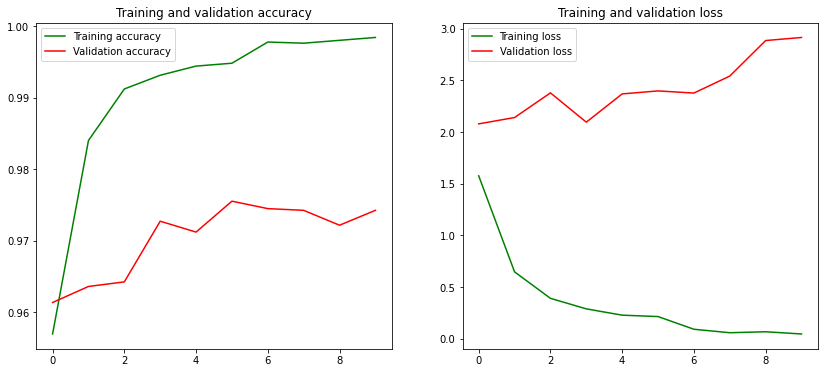

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 2.915374755859375
Validation accuracy: 0.9742400050163269


In [ ]:
#get the predictions for the test data
predicted_classes = model.predict(X_val)
#get the indices to) be plotted
y_true = np.argmax(y_val,axis=-1)

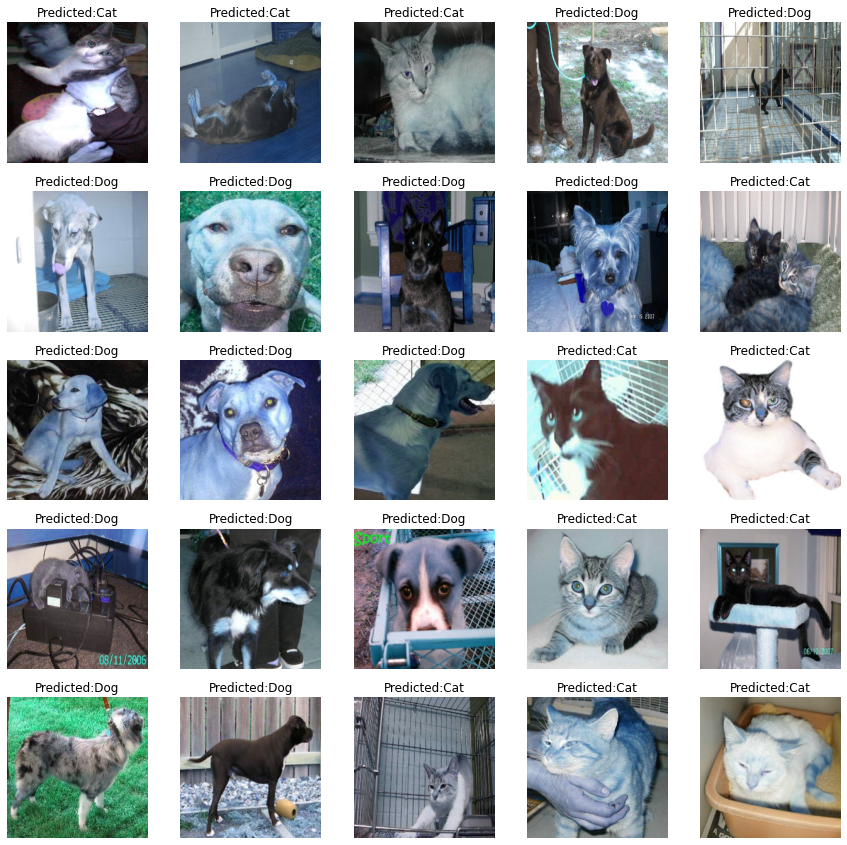

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test_data[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test_data):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(round(predicted[1]))

100%|██████████| 12500/12500 [11:50<00:00, 17.60it/s]


In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission_vgg16.csv", index=False)